In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import cv2
from keras import layers, models
from keras import applications
from keras import callbacks
import json
from pycocotools import mask as maskUtils


In [2]:
def preprocess_data(annotation):
    size = annotation['segmentation']['size']
    mask_encoded = annotation['segmentation']
    mask = maskUtils.decode(mask_encoded)
    return mask

In [3]:
with open('instances_750.json', 'r') as f:
    data = json.load(f)

In [4]:
images = []
image_id_to_index = {}
for idx, image_info in enumerate(data['images']):
    file_name = "train/" + image_info['file_name']
    image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image file '{file_name}' not found.")
    image = cv2.resize(image, (256, 256))
    images.append(image)
    image_id_to_index[image_info['id']] = idx

images = np.array(images)
annotations = data['annotations']
masks = np.zeros((len(images), 256, 256), dtype=np.uint8)

for annotation in annotations:
    image_id = annotation['image_id']
    mask = preprocess_data(annotation)
    mask = cv2.resize(mask, (256, 256))
    idx = image_id_to_index[image_id]
    masks[idx] = np.maximum(masks[idx], mask)

images = images / 255.0
masks = masks.astype(np.float32) 

In [5]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1. - score

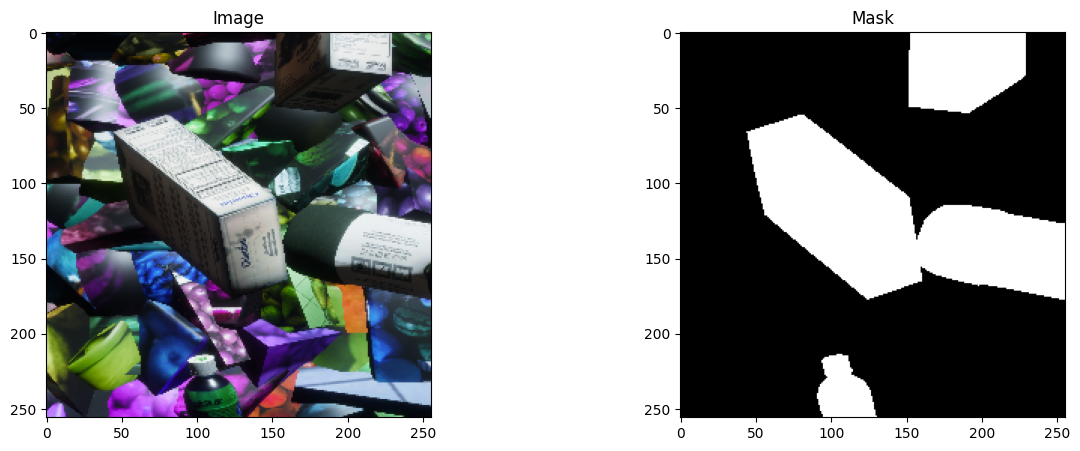

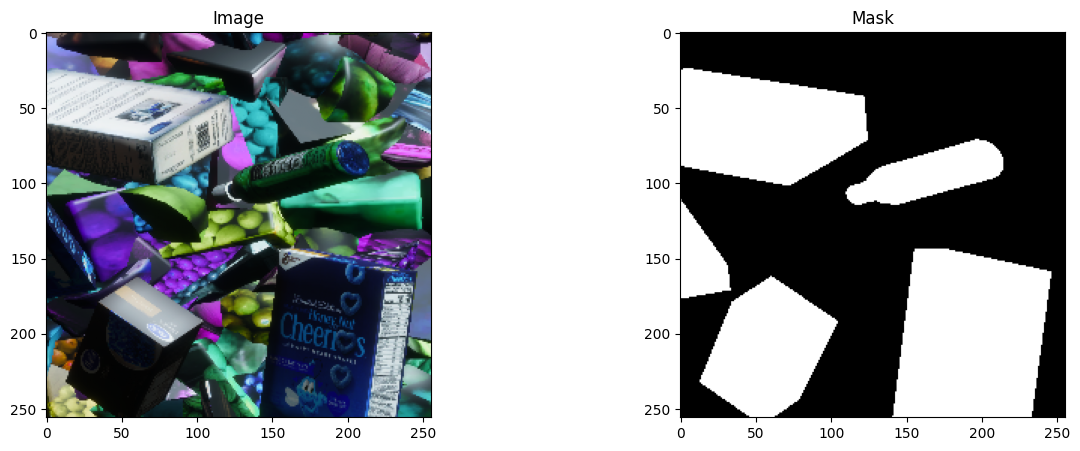

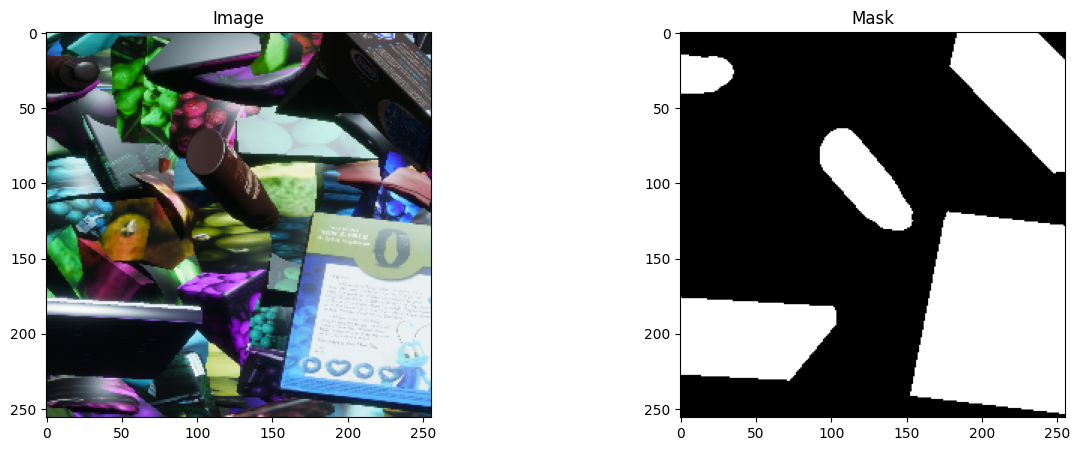

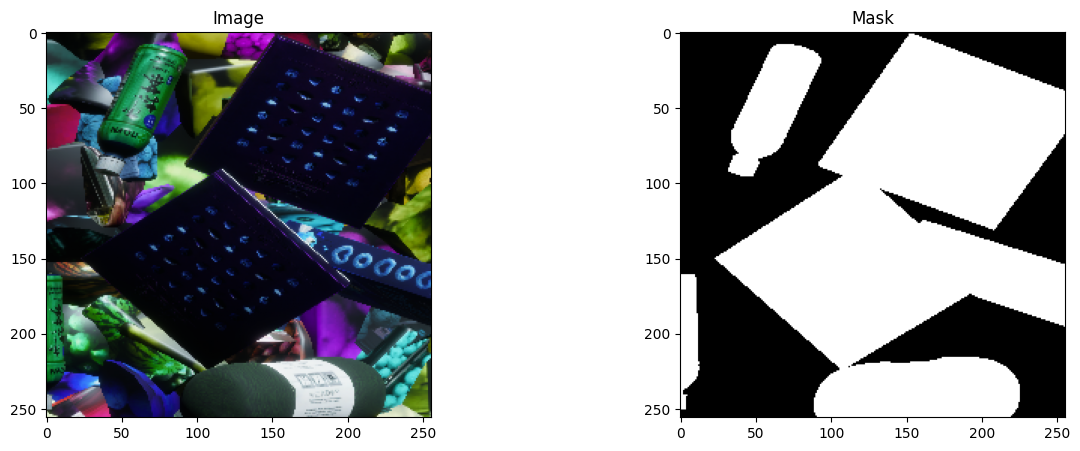

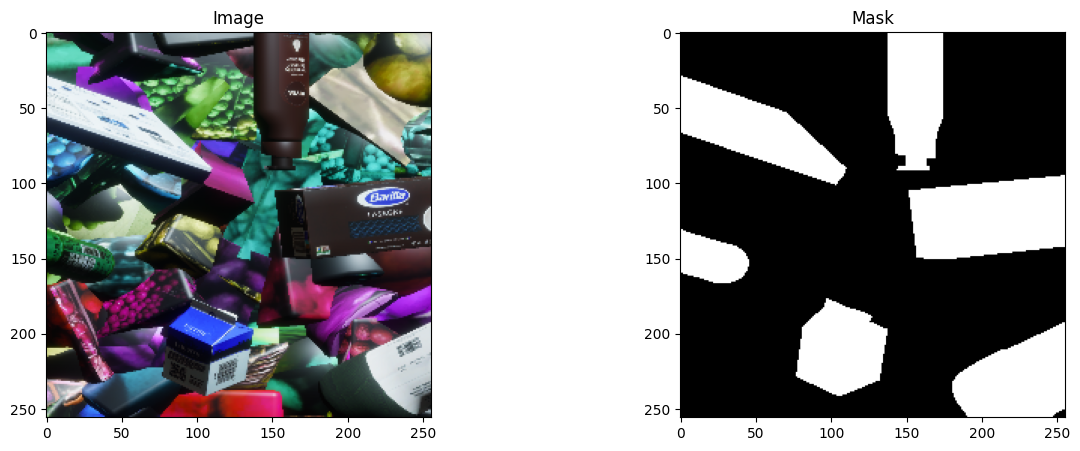

In [6]:
for i in range(5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(images[i])
    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.show()

In [7]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    base_model = applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = True

    for layer in base_model.layers[:20]:
        layer.trainable = False

    conv1 = base_model.get_layer('block2a_expand_activation').output
    conv2 = base_model.get_layer('block3a_expand_activation').output
    conv3 = base_model.get_layer('block4a_expand_activation').output
    conv4 = base_model.get_layer('block6a_expand_activation').output
    conv5 = base_model.get_layer('top_activation').output

    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    up10 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv9)
    conv10 = layers.Conv2D(32, 3, activation='relu', padding='same')(up10)
    conv10 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv10)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv10)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [8]:
input_shape = (256, 256, 3)
model = unet_model(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('unet_model2.keras', save_best_only=True, monitor='val_loss')

train_images, val_images = images[:600], images[600:]
train_masks, val_masks = masks[:600], masks[600:]

history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.4040 - loss: 0.5682 - val_accuracy: 0.3407 - val_loss: 0.5238
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.3535 - loss: 0.4935 - val_accuracy: 0.3407 - val_loss: 0.4930
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.3533 - loss: 0.4788 - val_accuracy: 0.3407 - val_loss: 0.4928
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3545 - loss: 0.4780 - val_accuracy: 0.3407 - val_loss: 0.4927
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.3508 - loss: 0.4812 - val_accuracy: 0.3407 - val_loss: 0.4927
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3573 - loss: 0.4741 - val_accuracy: 0.3407 - val_loss: 0.4927
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3429 - loss: 0.4903 - val_accuracy: 0.3407 - val_loss: 0.4927
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3520 - loss: 0.4802 - val_accuracy: 0.

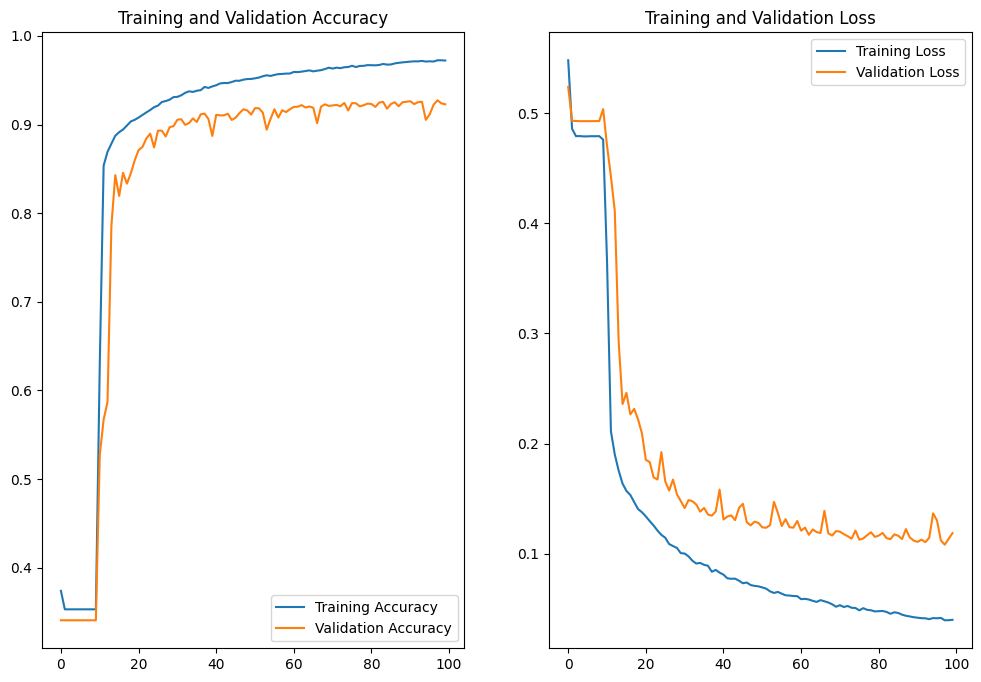

In [9]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training(history)

In [11]:
val_predictions = model.predict(val_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


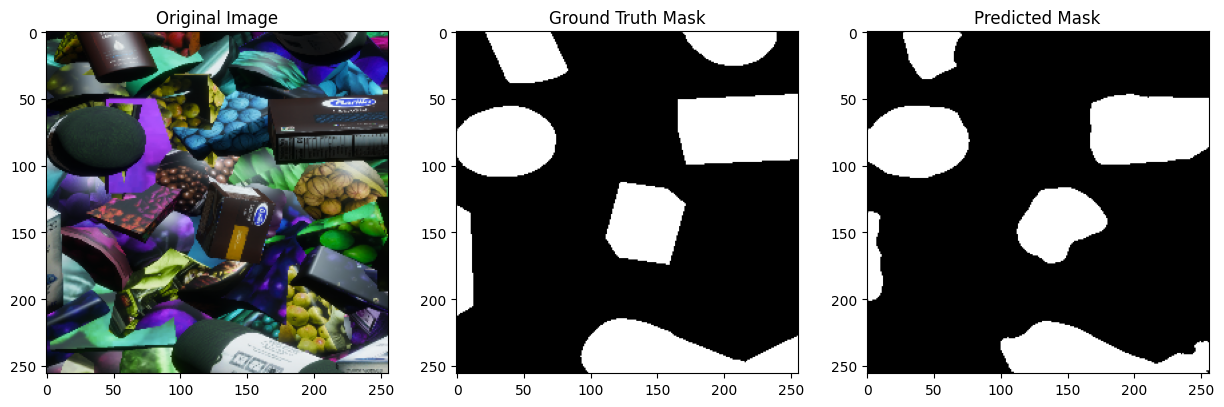

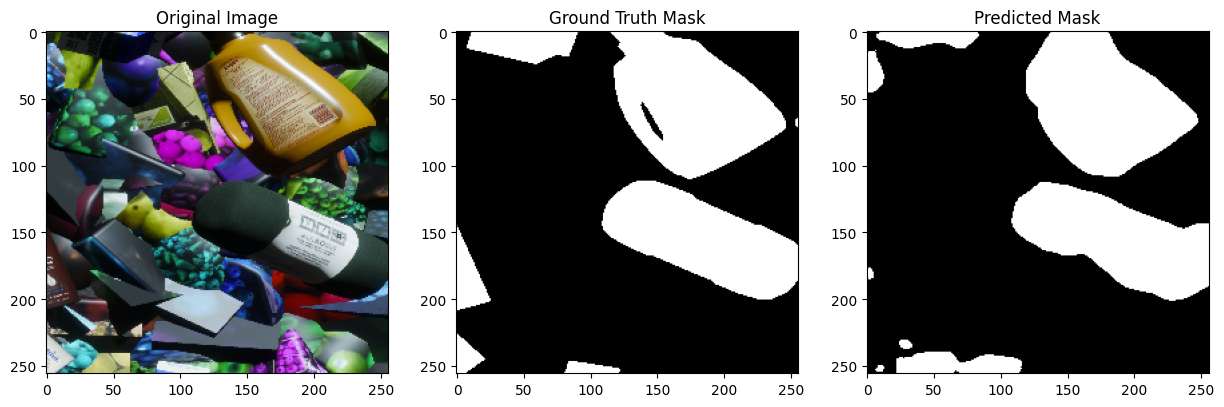

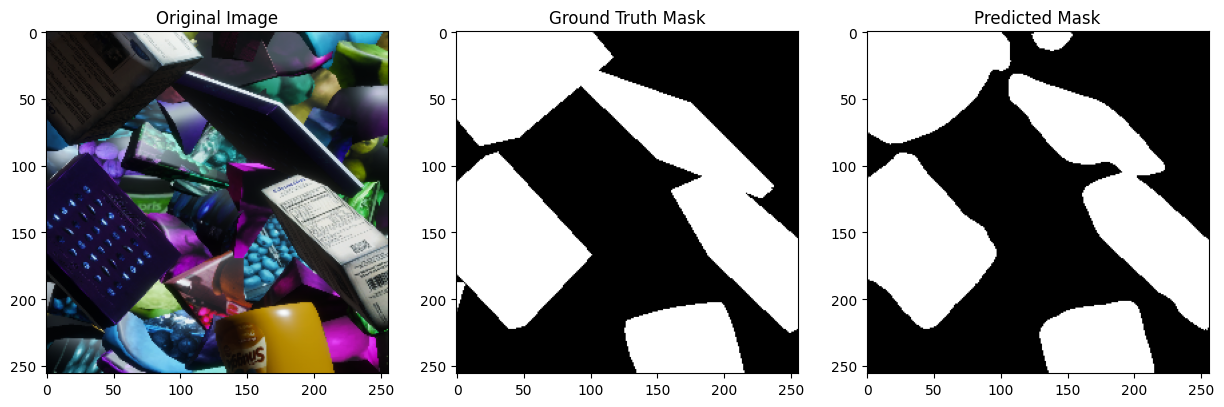

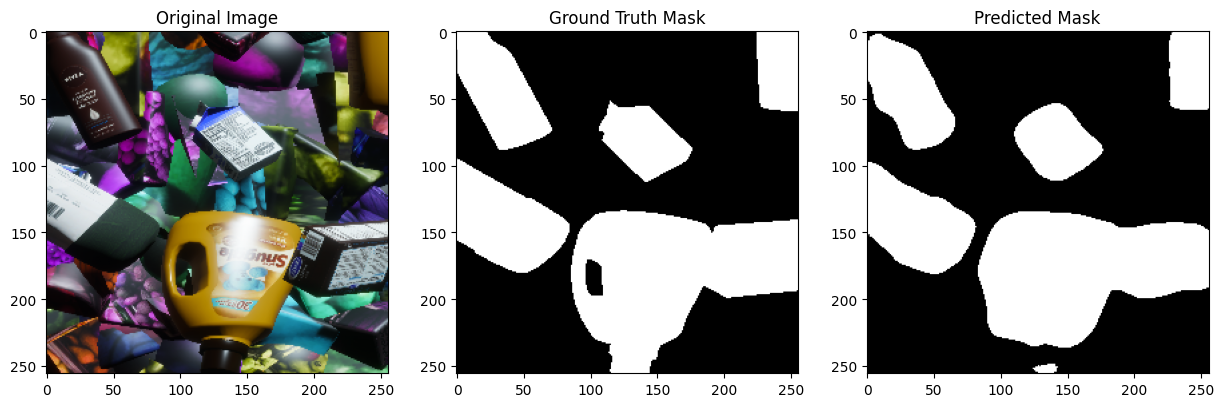

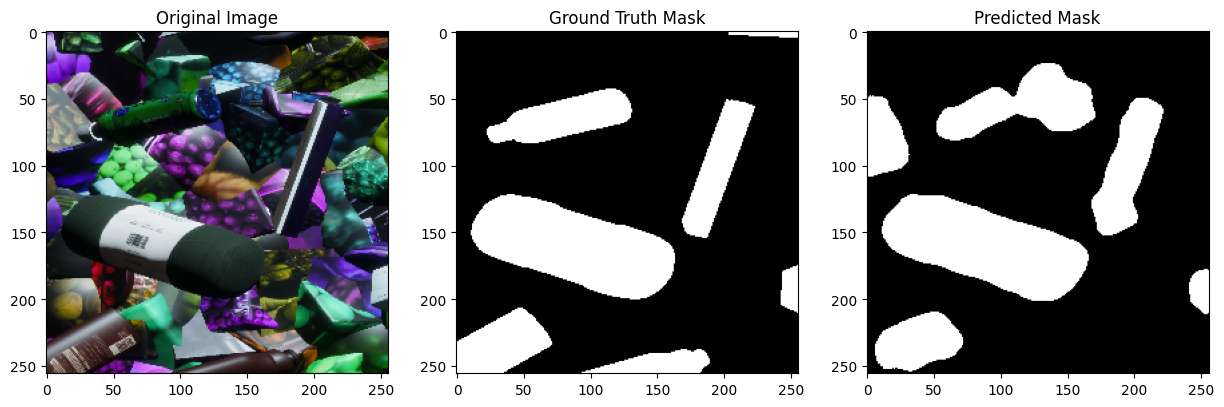

In [12]:
def display_prediction(image, mask, prediction, threshold=0.5):
    prediction = (prediction > threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(prediction, cmap='gray')

    plt.show()

for i in range(5):
    display_prediction(val_images[i], val_masks[i].squeeze(), val_predictions[i].squeeze())